In [2]:
### Binary classification -> Neural networks.
###classifying circles

In [3]:
##dependencies
from sklearn.datasets import make_circles #generate circles
import pandas as pd ##creating data frame
import matplotlib.pyplot as plt ##for drawing plots
import torch #creating tensors
from torch import nn ## basic building block of neural networks

In [4]:
## make   1000 samples 
n_samples = 1000
x, y = make_circles(
    n_samples,
    noise=0.03,
    random_state=42
)

In [5]:
## visualizing my data
##dataframe
circles = pd.DataFrame({
    'X1': x[:, 0], 
    'X2': x[:, 1],
    'Labels': y
})

circles.head(10)
##circles['Labels'].value_counts()

,X1,X2,Labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


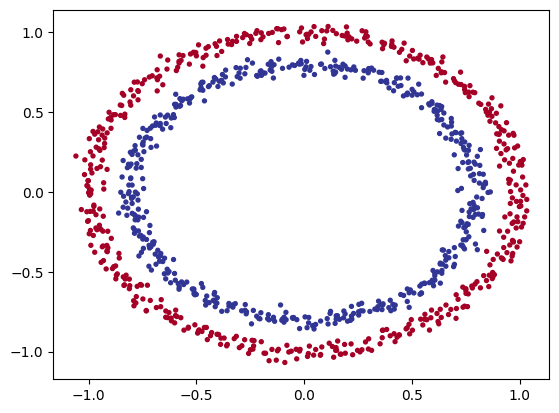

In [6]:
### drawing plots
plt.scatter(
    x=x[:,0],
    y=x[:,1],
    s=8,
    c=y,
    cmap=plt.cm.RdYlBu
)
plt.show()

In [7]:
##turn data into training and testing data
###input and output shapes 
##x.shape, y.shape

x_tensor = torch.from_numpy(x).type(torch.float)
y_tensor = torch.from_numpy(y).type(torch.float)

#x_tensor.shape, y_tensor.shape
#x_tensor, y_tensor

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    x_tensor,
    y_tensor, 
    test_size=0.2, #20% test data, 80% training data
    random_state=42
)

print(f"X training data: {len(X_train)}\nX Test Data: {len(X_test)}\n Y_train Data: {len(Y_train)}\n Y Test DATA: {len(Y_test)}")

X training data: 800
X Test Data: 200
 Y_train Data: 800
 Y Test DATA: 200


In [8]:
##device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [15]:
### create a model
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5), #2 inputs (x) with 1 hidden layer (5 neurons)
    nn.Linear(in_features=5, out_features=1) #1 output y
).to(device)

##model with relu activation
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() #relu activation function for non-linearity

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))) 

model_1 = CircleModelV2().to(device)
print(model_1)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [16]:
# Make predictions with the model
untrained_preds = model_1(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(Y_test)}, Shape: {Y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{Y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[ 0.0089],
        [-0.0154],
        [ 0.0231],
        [ 0.0010],
        [-0.0729],
        [-0.0844],
        [-0.0620],
        [-0.0912],
        [ 0.0273],
        [-0.0176]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [17]:
##loss function and optimizer
#loss_fn = torch.nn.BCELoss() # no sigmoid built in
loss_fn = torch.nn.BCEWithLogitsLoss() #sigmoid built in

#optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

#function to calculate accuracy of model
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() #find number of correct predictions
    acc = (correct/len(y_pred))*100
    return acc

In [18]:
##logits are unnormalized final scores of your model -> source: data science stack exchange
##training and testing our model

torch.manual_seed(40)

epochs = 1000 #train with 100 epochs 

#put train data and test data to device
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

#training loop

for epoch in range(epochs):
    model_1.train() #training mode

    #forward pass
    y_logits = model_1(X_train).squeeze() #squeeze to remove extra dimensions
    y_pred = torch.round(torch.sigmoid(y_logits)) #normalize using sigmoid fxn -> round to get prediction probabalities using round

    #calculate the loss
    loss = loss_fn(y_logits, Y_train) #not using sigmoid since BCEWithLogitsLoss has inbuilt sigmoid 

    acc = accuracy_fn(y_true=Y_train, 
    y_pred=y_pred)

    #optimizer zero grad
    optimizer.zero_grad()

    #loss backwards 
    loss.backward()

    #optmizer step -> apply gradient descent
    optimizer.step()

    ###testing 
    model_1.eval()
    with torch.inference_mode():
        #inference
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        #calculate test loss
        test_loss = loss_fn(test_logits, Y_test) 

        #test accuracy
        test_acc = accuracy_fn(
            y_true=Y_test,
            y_pred=test_pred
        )

    #print out whats happening 
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} ~ Loss: {loss:.5f}, Accuracy: {acc:.2f} ~ Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}")

Epoch: 0 ~ Loss: 0.69270, Accuracy: 49.25 ~ Test Loss: 0.69225, Test Accuracy: 48.50
Epoch: 10 ~ Loss: 0.69218, Accuracy: 50.25 ~ Test Loss: 0.69183, Test Accuracy: 49.00
Epoch: 20 ~ Loss: 0.69190, Accuracy: 50.12 ~ Test Loss: 0.69157, Test Accuracy: 49.50
Epoch: 30 ~ Loss: 0.69168, Accuracy: 50.75 ~ Test Loss: 0.69136, Test Accuracy: 50.00
Epoch: 40 ~ Loss: 0.69149, Accuracy: 50.75 ~ Test Loss: 0.69116, Test Accuracy: 51.50
Epoch: 50 ~ Loss: 0.69130, Accuracy: 50.88 ~ Test Loss: 0.69098, Test Accuracy: 50.00
Epoch: 60 ~ Loss: 0.69111, Accuracy: 51.12 ~ Test Loss: 0.69080, Test Accuracy: 50.00
Epoch: 70 ~ Loss: 0.69093, Accuracy: 51.88 ~ Test Loss: 0.69061, Test Accuracy: 50.00
Epoch: 80 ~ Loss: 0.69075, Accuracy: 52.12 ~ Test Loss: 0.69042, Test Accuracy: 50.00
Epoch: 90 ~ Loss: 0.69058, Accuracy: 52.12 ~ Test Loss: 0.69023, Test Accuracy: 49.00
Epoch: 100 ~ Loss: 0.69040, Accuracy: 52.38 ~ Test Loss: 0.69003, Test Accuracy: 51.50
Epoch: 110 ~ Loss: 0.69022, Accuracy: 52.12 ~ Test Los

In [19]:
# Fit the model
torch.manual_seed(42)
epochs = 700

# Put all data on target device
X_train, y_train = X_train.to(device), Y_train.to(device)
X_test, y_test = X_test.to(device), Y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_1(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.63536, Accuracy: 63.38% | Test Loss: 0.63967, Test Accuracy: 64.50%
Epoch: 100 | Loss: 0.60446, Accuracy: 78.38% | Test Loss: 0.61369, Test Accuracy: 75.00%
Epoch: 200 | Loss: 0.54682, Accuracy: 93.12% | Test Loss: 0.56252, Test Accuracy: 92.50%
Epoch: 300 | Loss: 0.45221, Accuracy: 98.75% | Test Loss: 0.47180, Test Accuracy: 98.00%
Epoch: 400 | Loss: 0.33886, Accuracy: 99.62% | Test Loss: 0.36530, Test Accuracy: 98.00%
Epoch: 500 | Loss: 0.23296, Accuracy: 99.88% | Test Loss: 0.26887, Test Accuracy: 98.00%
Epoch: 600 | Loss: 0.15491, Accuracy: 100.00% | Test Loss: 0.19417, Test Accuracy: 98.50%


In [22]:
##evaluating model predictions 
# Make predictions
model_1.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_1(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0], dtype=int64))

helper_functions.py already exists, skipping download


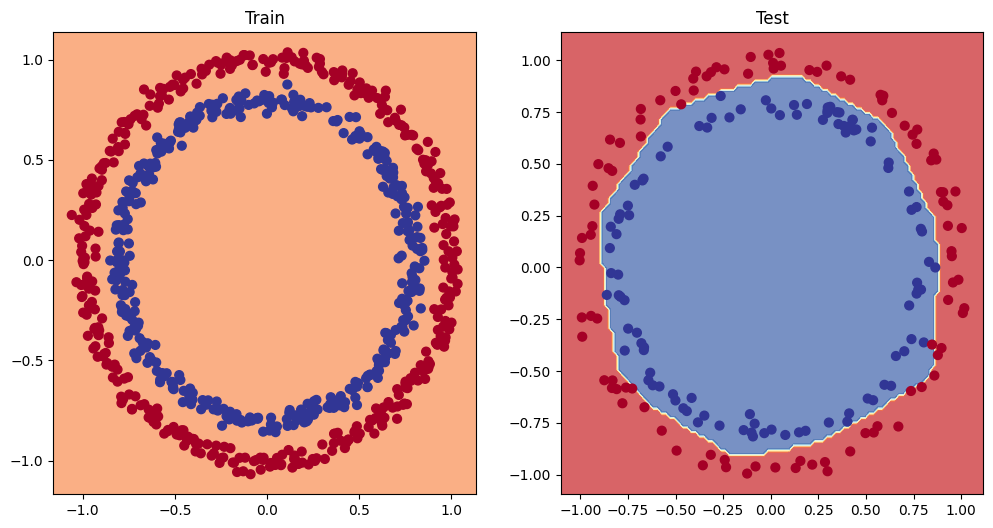

In [24]:
#visualizing predictions
import requests
from pathlib import Path 
# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, Y_test)